In [176]:
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
sns.set_theme()
register_matplotlib_converters()

In [177]:
df = pd.read_csv("historical-daily-weather\Prepped data.csv", index_col="date")
df.head()

,daily_rainfall_total,mean_temperature,maximum_temperature,minimum_temperature,mean_wind_speed,max_wind_speed,temperature_range
date,,,,,,,
2009-01-24,0.0,26.80,31.4,24.4,11.7,38.2,7.0
2009-01-25,0.8,25.90,27.8,24.4,12.7,38.2,3.4
2009-01-26,0.0,25.90,29.6,23.7,12.4,42.5,5.9
2009-01-27,0.0,26.25,30.2,23.7,10.4,38.9,6.5
2009-01-28,0.0,26.60,31.9,23.7,10.3,32.4,8.2


In [178]:
df.index = pd.to_datetime(df.index, infer_datetime_format=True)
df.head()

,daily_rainfall_total,mean_temperature,maximum_temperature,minimum_temperature,mean_wind_speed,max_wind_speed,temperature_range
date,,,,,,,
2009-01-24,0.0,26.80,31.4,24.4,11.7,38.2,7.0
2009-01-25,0.8,25.90,27.8,24.4,12.7,38.2,3.4
2009-01-26,0.0,25.90,29.6,23.7,12.4,42.5,5.9
2009-01-27,0.0,26.25,30.2,23.7,10.4,38.9,6.5
2009-01-28,0.0,26.60,31.9,23.7,10.3,32.4,8.2


In [179]:
plt.rc("figure",figsize=(16, 12))
plt.rc("font",size=13)

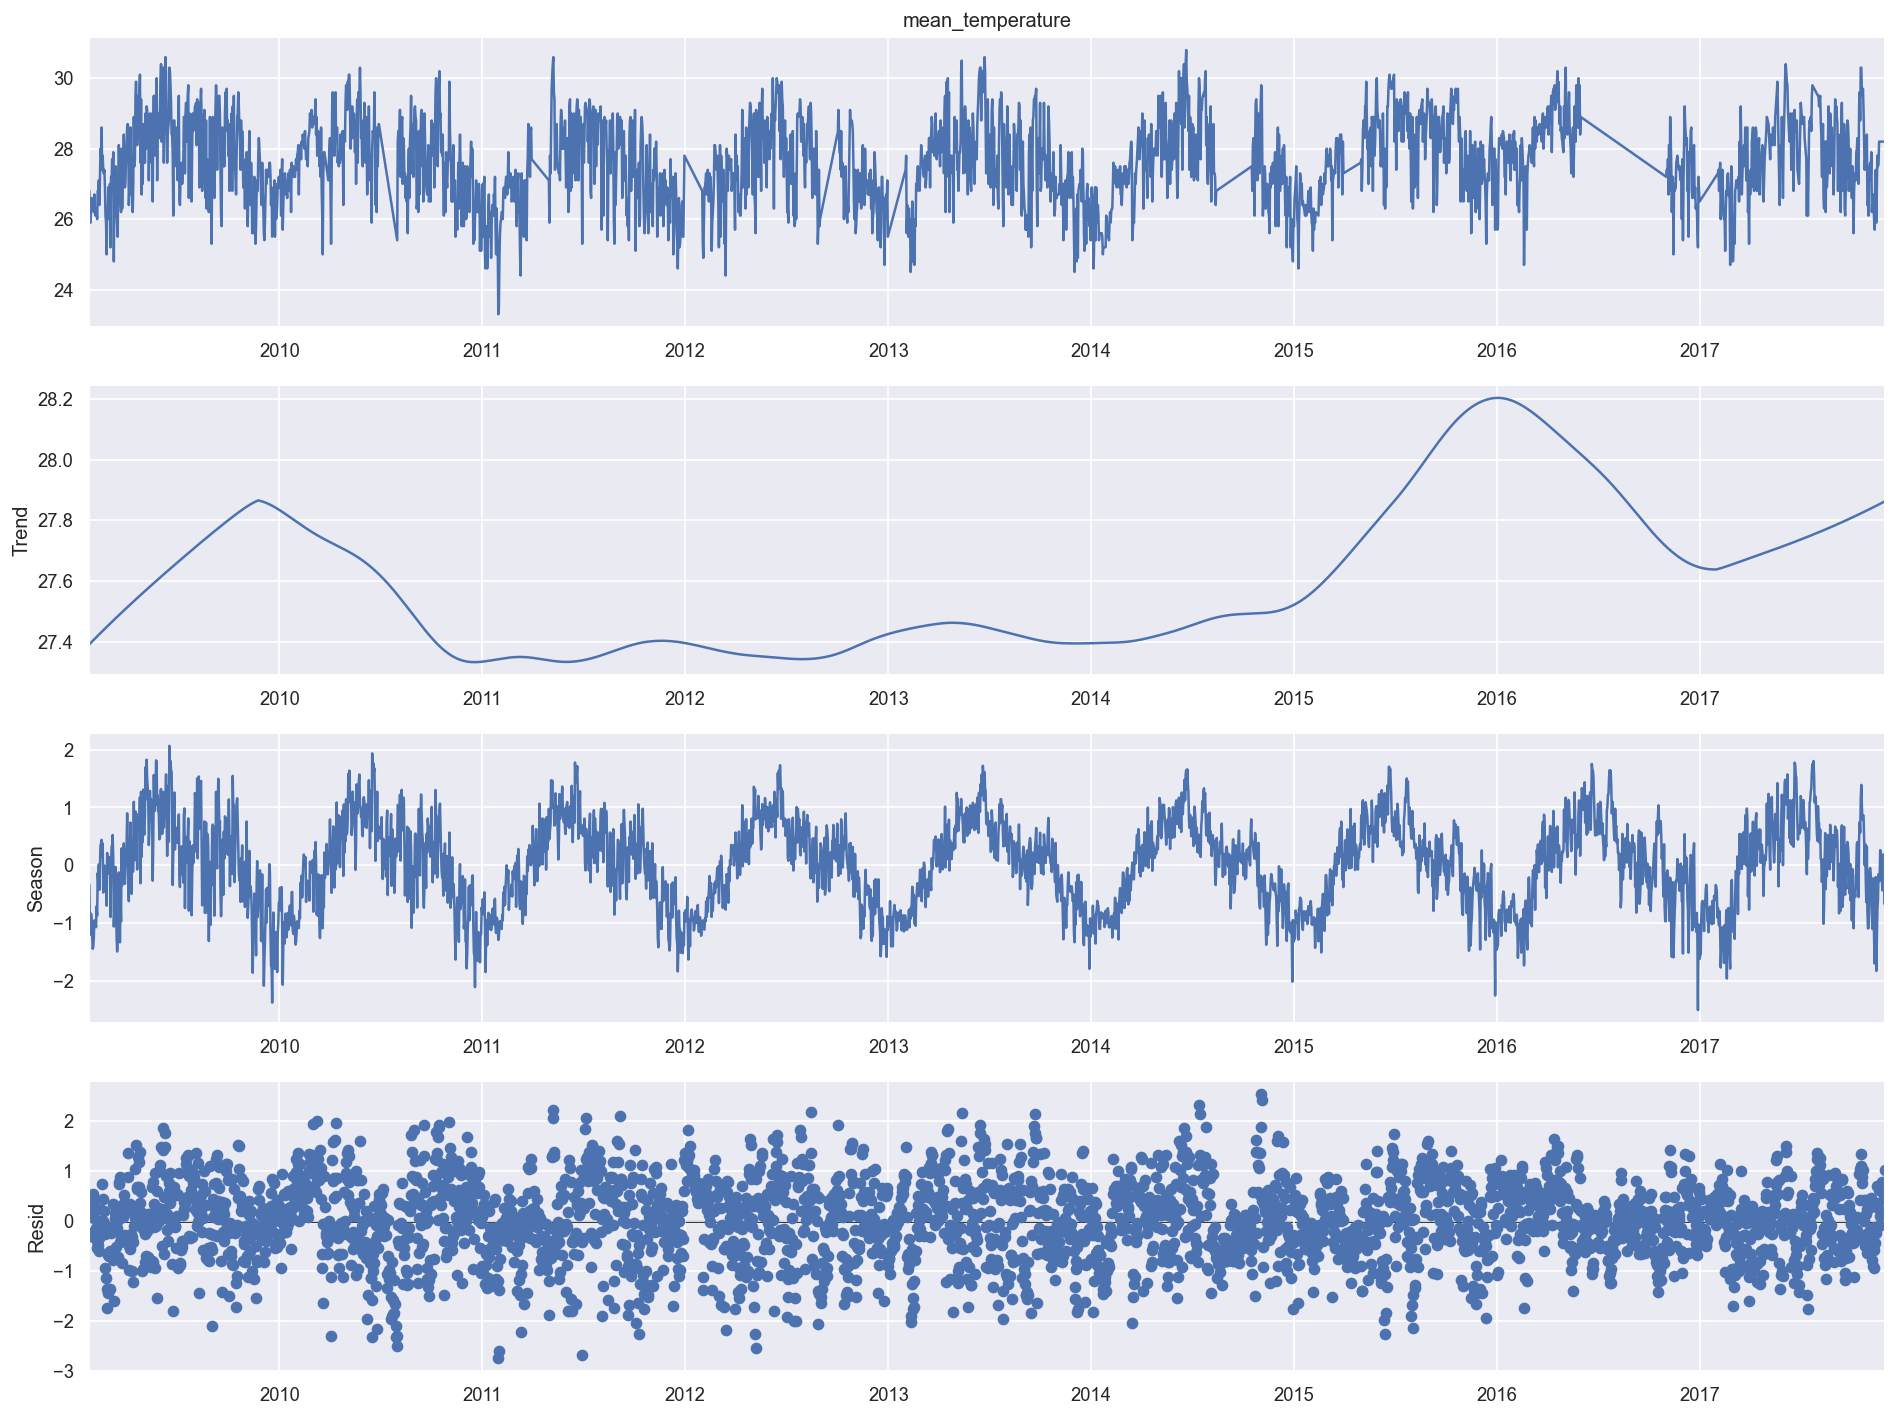

In [180]:
from statsmodels.tsa.seasonal import STL
stl = STL(df["mean_temperature"],period=365,seasonal=15)
res = stl.fit()
fig = res.plot()

In [181]:
#Monthly aggregate
df_m = df.resample('MS').mean()
df_m.head()

,daily_rainfall_total,mean_temperature,maximum_temperature,minimum_temperature,mean_wind_speed,max_wind_speed,temperature_range
date,,,,,,,
2009-01-01,0.100000,26.331250,30.212500,24.100000,11.225000,37.100000,6.112500
2009-02-01,5.285714,26.767857,31.442857,24.260714,9.564286,35.842857,7.182143
2009-03-01,11.435484,26.938710,32.117742,24.000000,7.112903,35.674194,8.117742
2009-04-01,4.960000,28.120000,32.196667,25.066667,7.363333,35.086667,7.130000
2009-05-01,6.632258,28.483871,32.590323,25.093548,7.451613,36.103226,7.496774


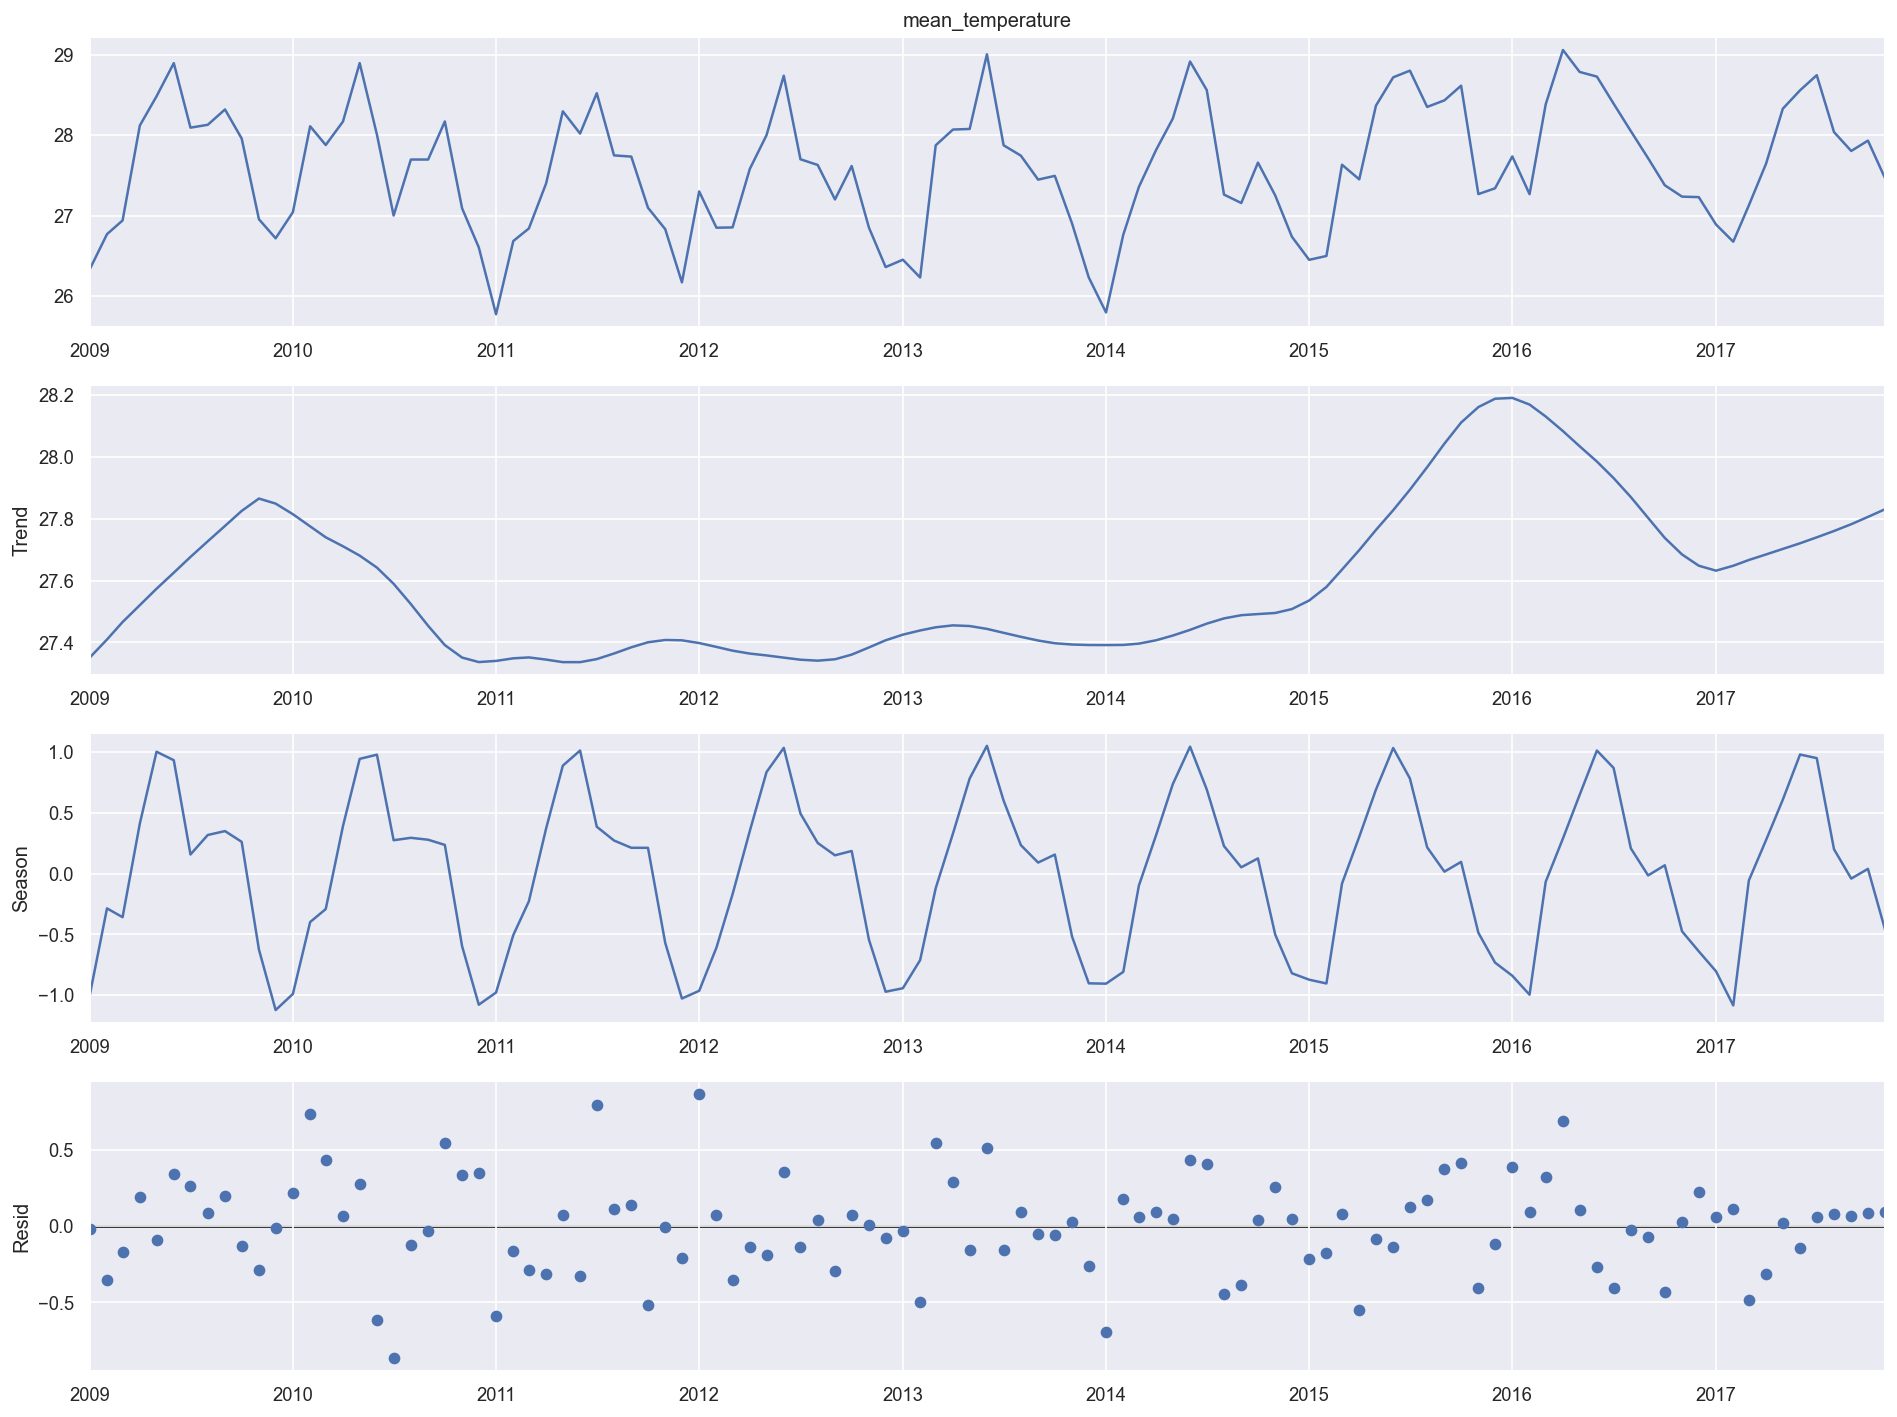

In [182]:
stl = STL(df_m["mean_temperature"],period=12,seasonal=15)
res = stl.fit()
fig = res.plot()

General increasing trend in mean temperatures with spikes from 2009 to 2010 and 2015 to 2016. Looking at the seasonsality, mean temperatures peak in May and June and are lowest in January and February.

#Check if time series is stationary or not

In [183]:
#Function to perform Augmented Dickey Fuller test to see if time series data is stationary or not
from statsmodels.tsa.stattools import adfuller

adftest = adfuller(df_m['mean_temperature'], autolag='AIC')
dfoutput = pd.Series(adftest[0:4], index=['Test statistic','p-value','#Lags used','Number of observations'])
for key,value in adftest[4].items():
    dfoutput['Critical value (%s)'%key] = value
print (dfoutput)

Test statistic            -1.481153
p-value                    0.542813
#Lags used                11.000000
Number of observations    95.000000
Critical value (1%)       -3.501137
Critical value (5%)       -2.892480
Critical value (10%)      -2.583275
dtype: float64


p-value > significance level of 0.05 - do not reject null hypothesis that time series is non-stationary and take time series to be non-stationary

In [184]:
adftest = adfuller(df_m['mean_temperature'].diff().dropna(), autolag='AIC')
dfoutput = pd.Series(adftest[0:4], index=['Test statistic','p-value','#Lags used','Number of observations'])
for key,value in adftest[4].items():
    dfoutput['Critical value (%s)'%key] = value
print (dfoutput)

Test statistic           -7.449705e+00
p-value                   5.713411e-11
#Lags used                1.000000e+01
Number of observations    9.500000e+01
Critical value (1%)      -3.501137e+00
Critical value (5%)      -2.892480e+00
Critical value (10%)     -2.583275e+00
dtype: float64


1st order differencing makes time series stationary

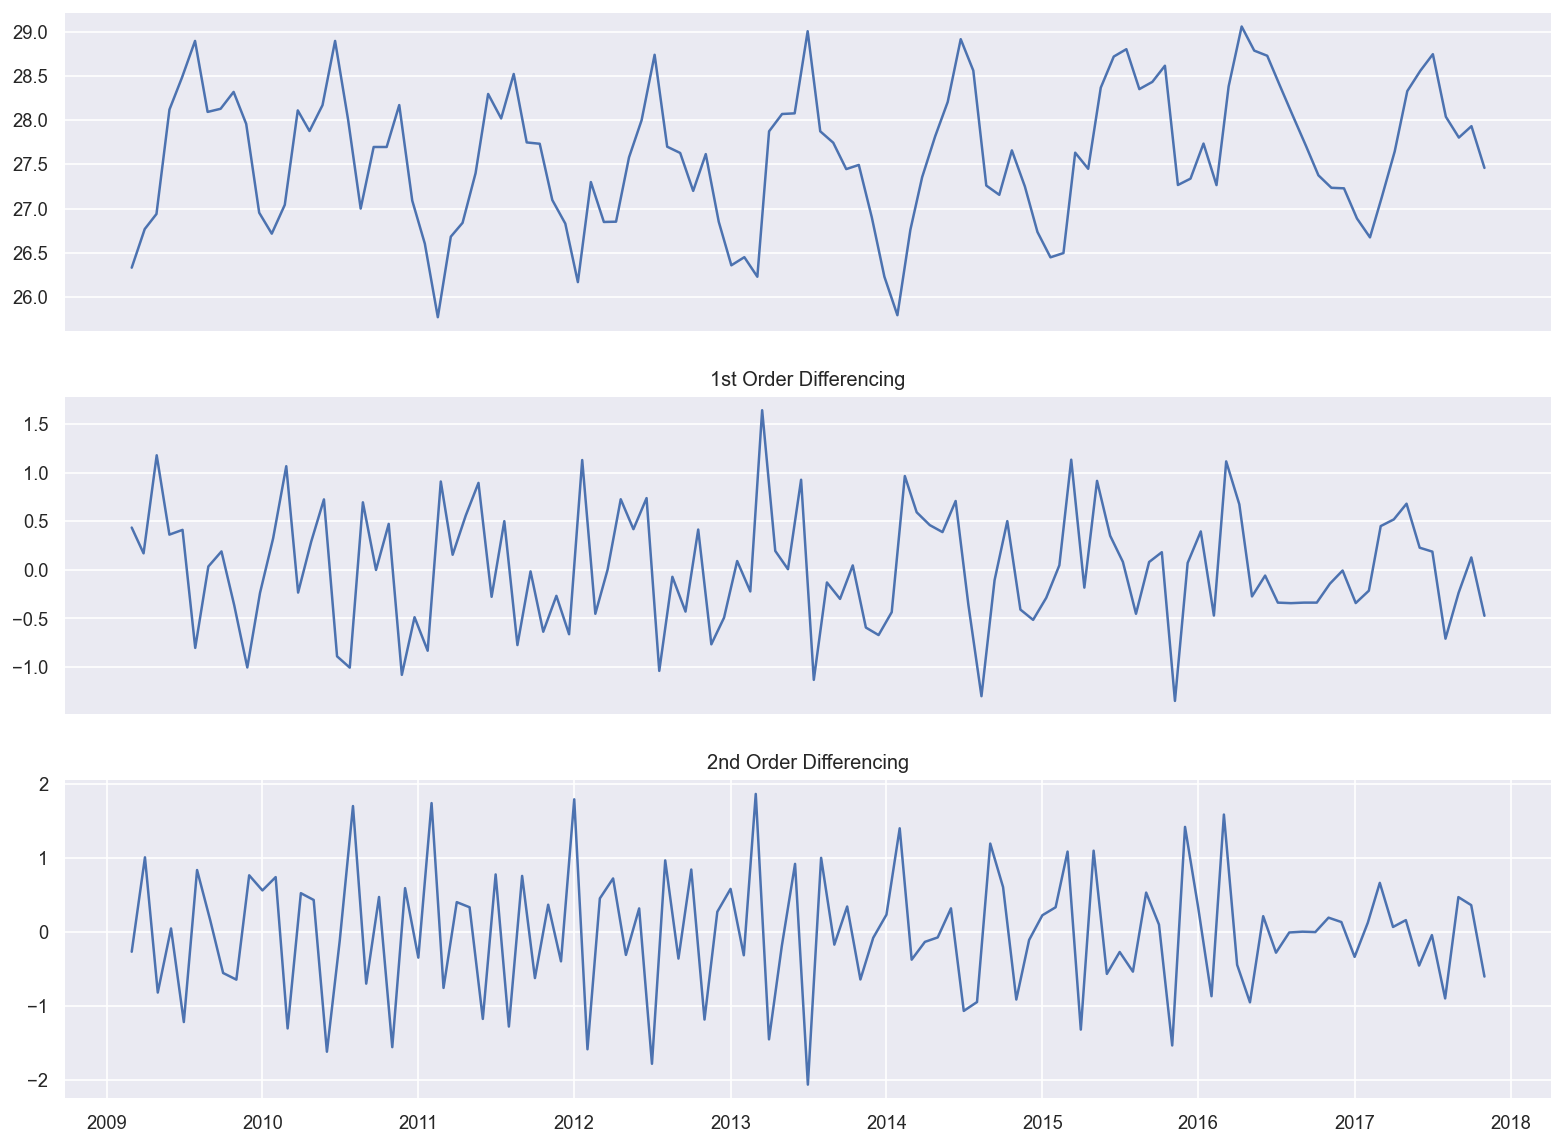

In [185]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df_m['mean_temperature']); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df_m['mean_temperature'].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df_m['mean_temperature'].diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

1st order differencing makes time series stationary and 2nd order differencing introduces more noise to the time series data

In [186]:
#Split train test data
train = df_m.loc[:'2016-12-01']
test = df_m.loc['2017-01-01':]

#Holt-Winters Exponential Smoothing

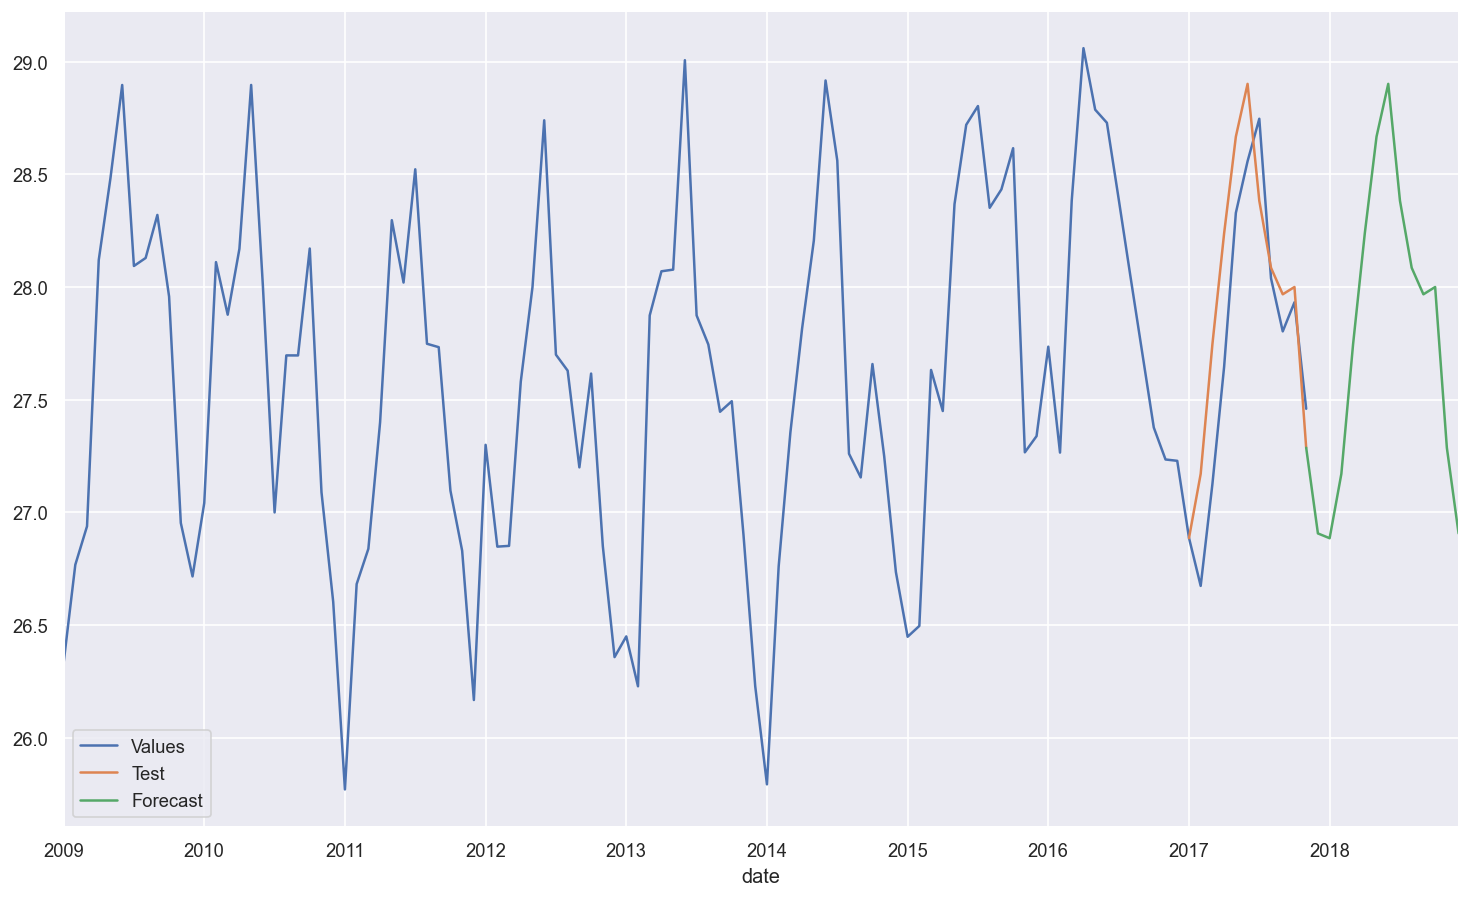

Mean absolute error: 0.2917644382086234


<Figure size 1920x1440 with 0 Axes>

In [187]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing   

# train model and predict
hwmodel = ExponentialSmoothing(train["mean_temperature"], seasonal='mul', seasonal_periods=12).fit()
pred_test = hwmodel.predict(start='2017-01-01', end='2017-11-01')
pred_forecast = hwmodel.predict(start='2017-11-01', end='2018-12-01')

# plot data and prediction
df_m["mean_temperature"].plot(figsize=(15,9), label='Values')
pred_test.plot(label='Test')
pred_forecast.plot(label='Forecast')
plt.legend()
plt.show()
plt.savefig('figure.png')

import sklearn
from sklearn.metrics import mean_absolute_error

print(f"Mean absolute error: {mean_absolute_error(test['mean_temperature'],pred_test)}")

#Seasonal Autoregressive Integrated Moving Average (SARIMA)

c:\Users\waiho\anaconda3\envs\myenv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


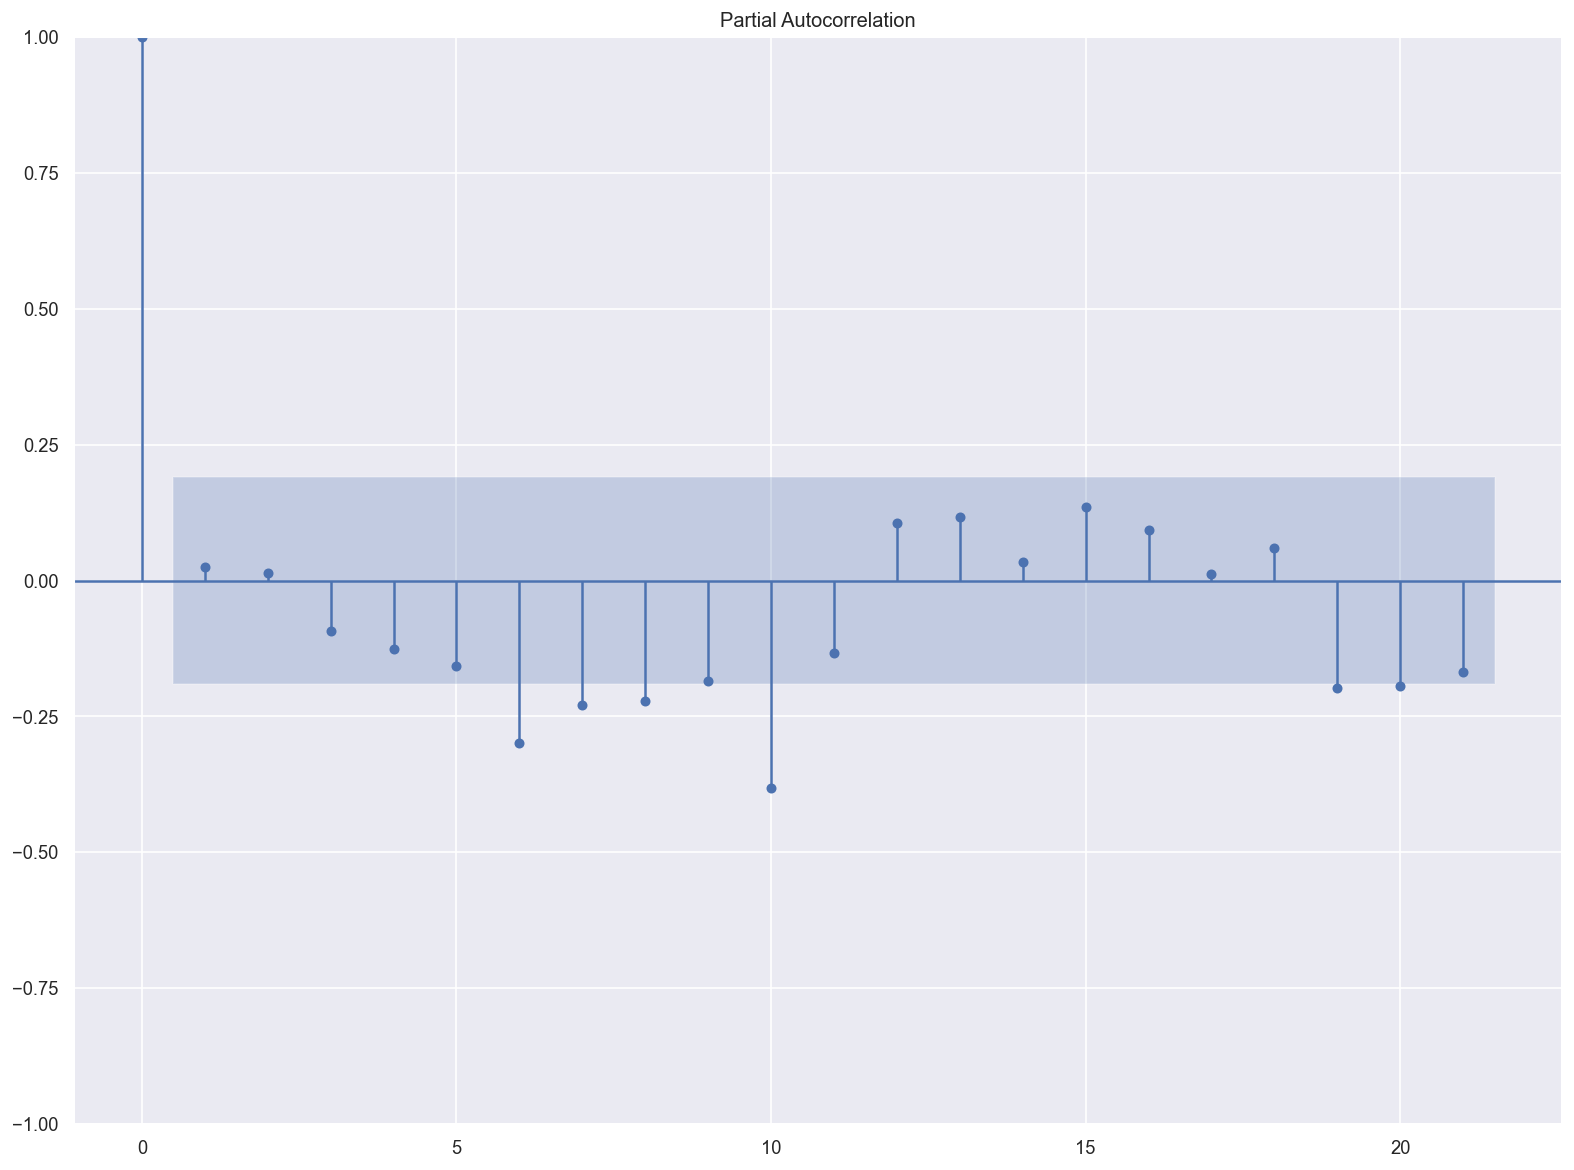

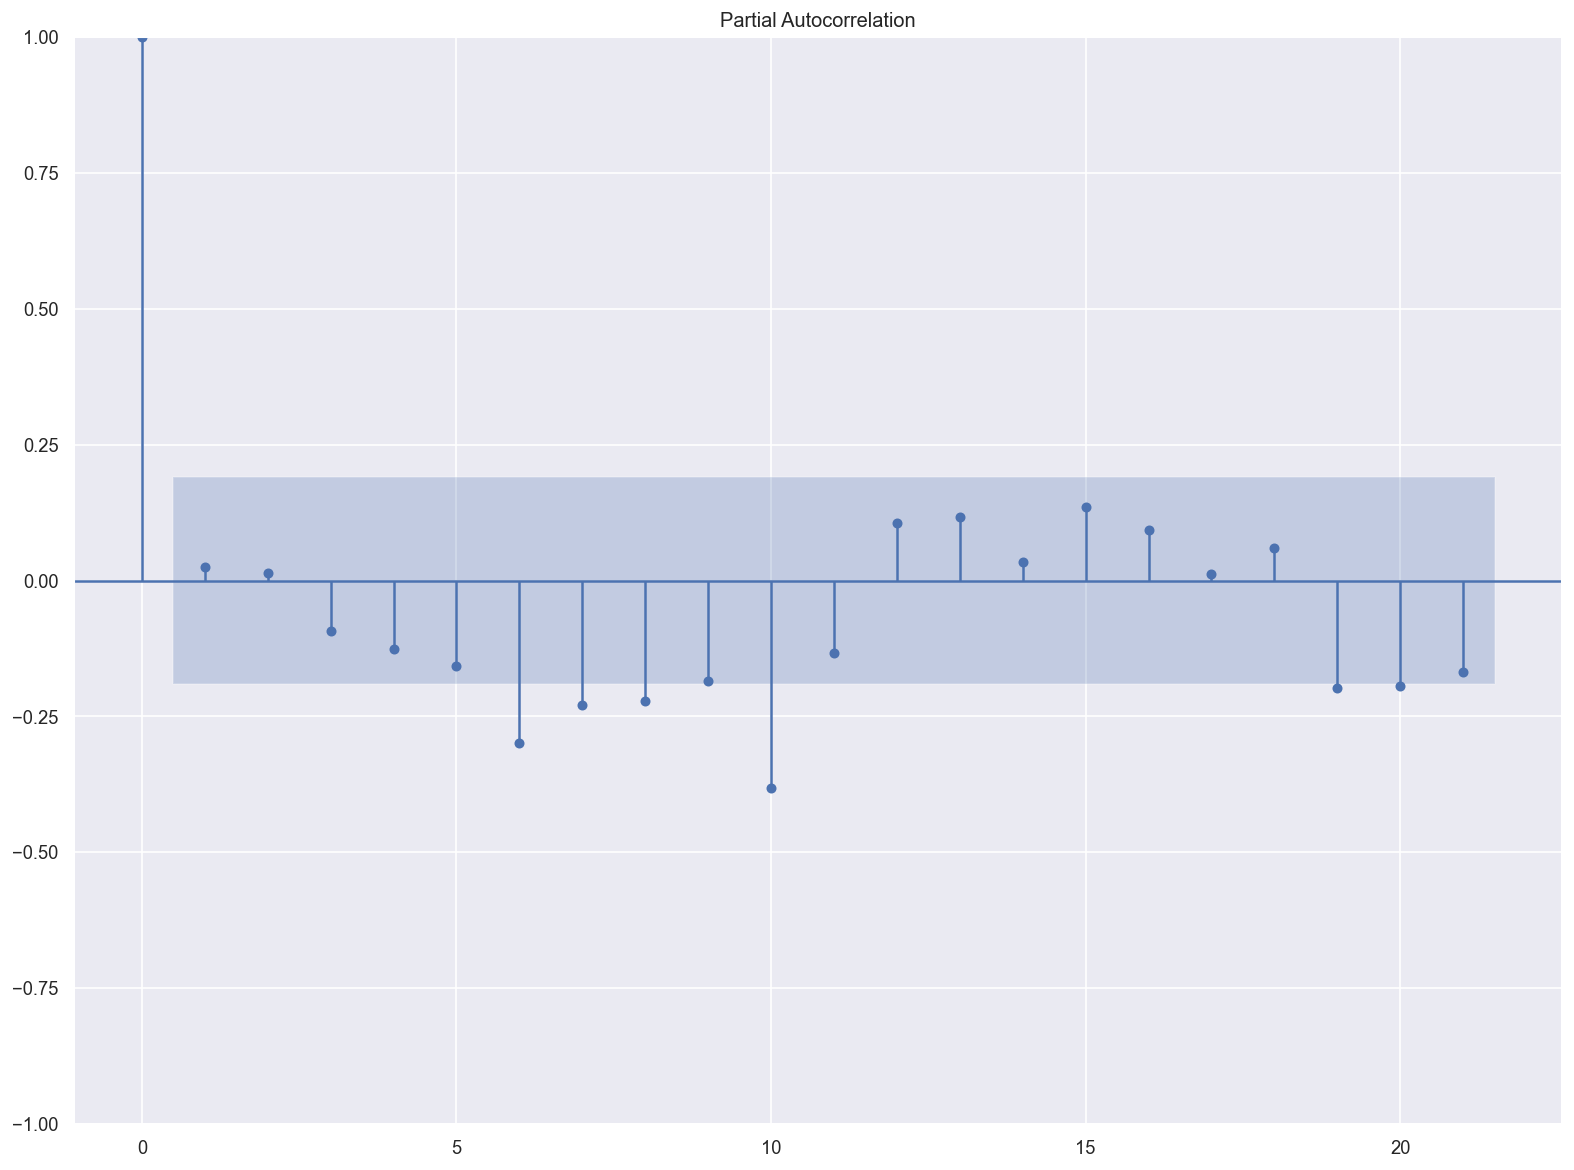

In [188]:
#Determining order of AR term (p)
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_m["mean_temperature"].diff().dropna())

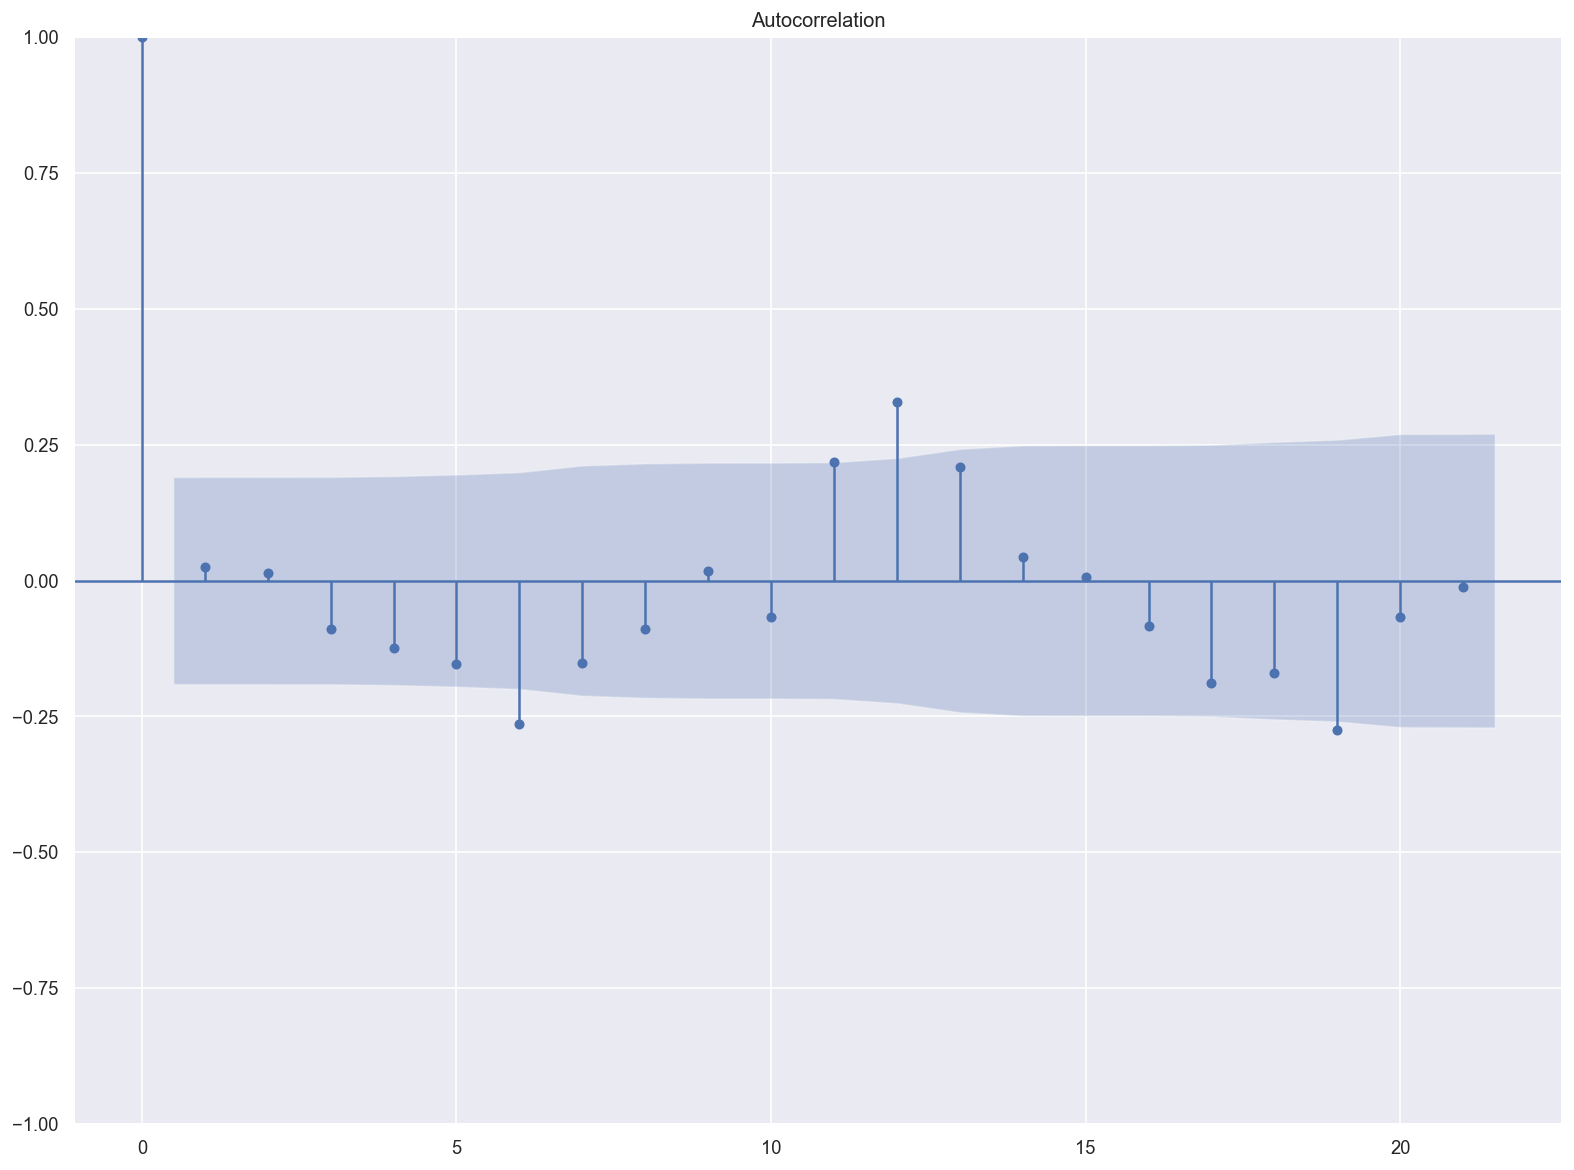

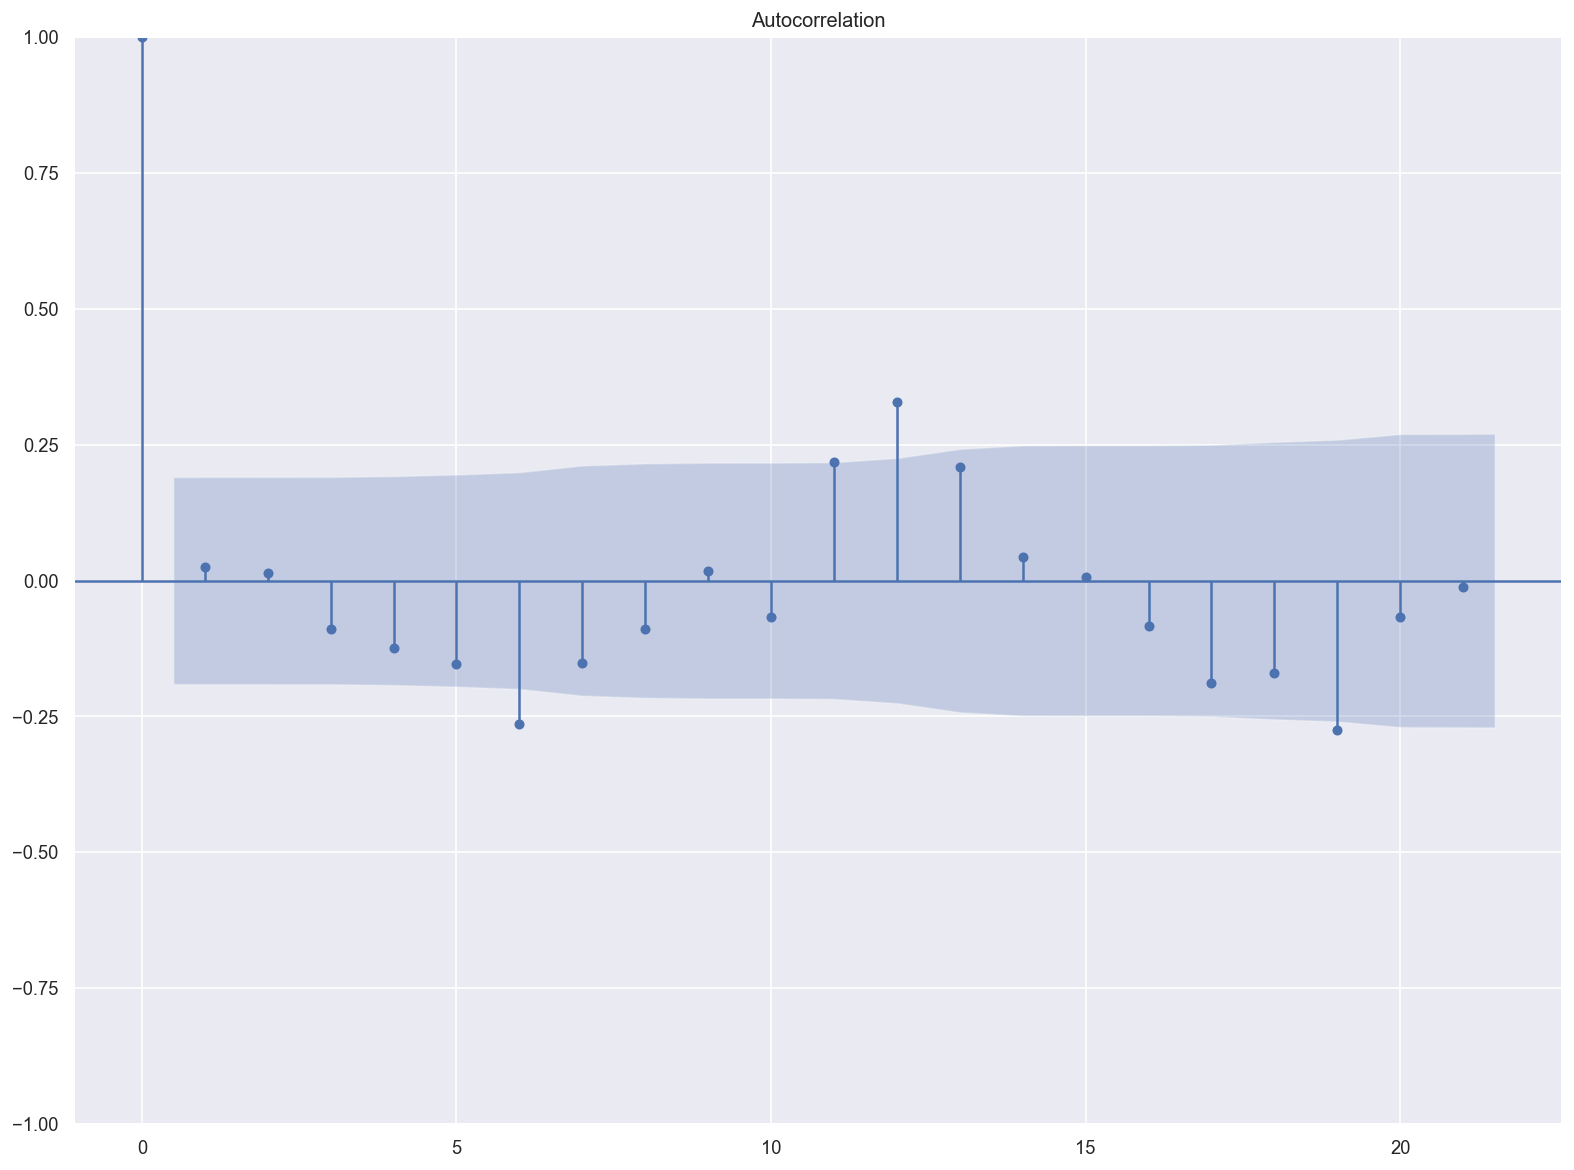

In [189]:
#Determining order of MA term (q)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_m['mean_temperature'].diff().dropna())

In [218]:
#Use auto_arima to find the optimal model
from pmdarima.arima import auto_arima
auto_arima(df_m['mean_temperature'],start_p=0,start_q=0,max_p=10,max_q=10,start_P=0,start_Q=0,max_P=10,max_D=2,max_Q=10,d=1,m=12,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=198.692, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=187.175, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=192.842, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=196.725, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=200.630, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=179.013, Time=0.13 sec
 ARIMA(1,1,0)(3,0,0)[12] intercept   : AIC=173.763, Time=0.36 sec
 ARIMA(1,1,0)(4,0,0)[12] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(1,1,0)(3,0,1)[12] intercept   : AIC=174.862, Time=0.61 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=173.798, Time=0.29 sec
 ARIMA(1,1,0)(4,0,1)[12] intercept   : AIC=176.782, Time=2.08 sec
 ARIMA(0,1,0)(3,0,0)[12] intercept   : AIC=178.954, Time=0.27 sec
 ARIMA(2,1,0)(3,0,0)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(1,1,1)(3,0,0)[12] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,1,1)(3,0,0)[12] intercept   : AIC=16

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

c:\Users\waiho\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\waiho\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\waiho\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


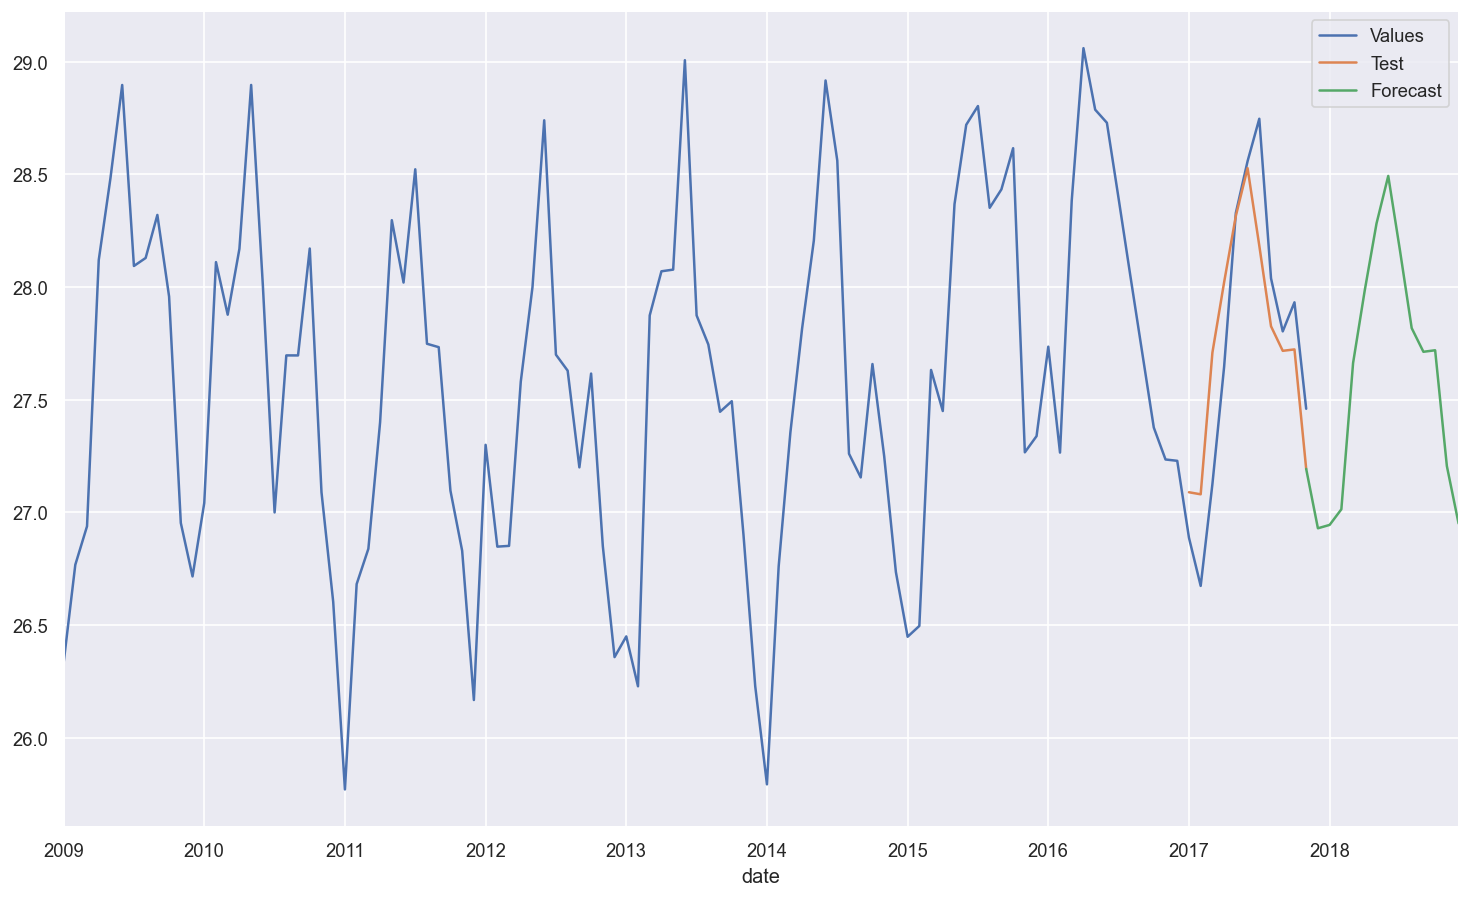

Mean absolute error: 0.2680012150241844


<Figure size 1920x1440 with 0 Axes>

In [219]:
from statsmodels.tsa.arima.model import ARIMA   

# train model and predict
# use order and seasonal order determined earlier
arimamodel = ARIMA(train["mean_temperature"],order=(2,1,2),seasonal_order=(1,0,1,12)).fit()
pred_test = arimamodel.predict(start='2017-01-01', end='2017-11-01')
pred_forecast = arimamodel.predict(start='2017-11-01', end='2018-12-01')

# plot data and prediction
df_m["mean_temperature"].plot(figsize=(15,9), label='Values')
pred_test.plot(label='Test')
pred_forecast.plot(label='Forecast')
plt.legend()
plt.show()
plt.savefig('figure.png')

import sklearn
from sklearn.metrics import mean_absolute_error

print(f"Mean absolute error: {mean_absolute_error(test['mean_temperature'],pred_test)}")